In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'#,3'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical
from keras import callbacks

Using TensorFlow backend.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import util, defs

In [6]:
f_bg = np.load('particles_jj.npz')
bg_jets = f_bg['jets']
bg_consts = f_bg['constituents'][:,:defs.N_CONST]

f_sig = np.load('particles_yz.npz')
sig_jets = f_sig['jets']
sig_photons = f_sig['photons']
sig_consts = f_sig['constituents'][:,:defs.N_CONST]

bg_pass = (bg_jets[:,3]>defs.JET_MASS_MIN)*(bg_jets[:,0]>defs.JET_PT_MIN)
sig_pass = (sig_jets[:,3]>defs.JET_MASS_MIN)*(sig_jets[:,0]>defs.JET_PT_MIN)

bg_jets = bg_jets[bg_pass]
bg_consts = bg_consts[bg_pass]
sig_jets = sig_jets[sig_pass]
sig_consts = sig_consts[sig_pass]

sig_photons = sig_photons[sig_pass]

bg_consts[:,:,0][bg_consts[:,:,0]<defs.MIN_PT] = 0
sig_consts[:,:,0][sig_consts[:,:,0]<defs.MIN_PT] = 0


nc_bg = np.sum(bg_consts[:,:,0]>0, axis=-1)
nc_sig = np.sum(sig_consts[:,:,0]>0, axis=-1)

#bg_consts = bg_consts[nc_bg>2]
#bg_jets = bg_jets[nc_bg>2]
#sig_consts = sig_consts[nc_sig>2]
#sig_jets = sig_jets[nc_sig>2]

#nc_bg = np.sum(bg_consts[:,:,0]>0, axis=-1)
#nc_sig = np.sum(sig_consts[:,:,0]>0, axis=-1)
    
print(bg_consts.shape)
print(sig_consts.shape)

(297233, 96, 3)
(392759, 96, 3)


In [7]:
sig_photons.shape

(392759, 3)

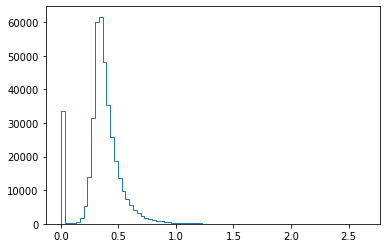

In [8]:
plt.hist(sig_photons[:,0], histtype='step', bins=80);

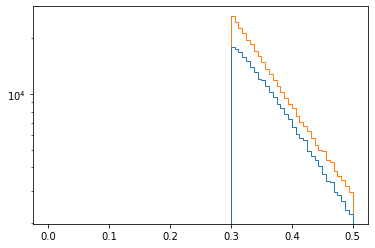

In [9]:
plt.hist([bg_jets[:,0], sig_jets[:,0]], histtype='step', bins=80, range=(0,0.5));
plt.yscale('log');

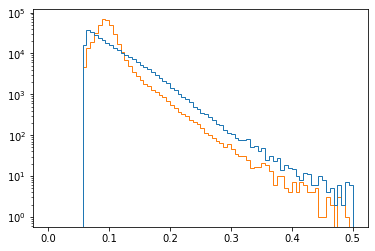

In [10]:
plt.hist([bg_jets[:,3], sig_jets[:,3]], histtype='step', bins=80, range=(0,0.5));
plt.yscale('log');

Text(0, 0.5, '∆R(jet, photon)')

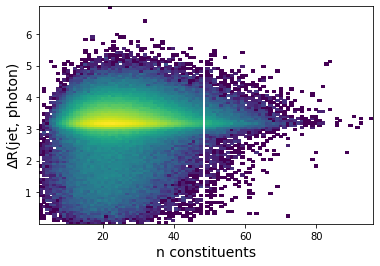

In [11]:
from matplotlib.colors import LogNorm
plt.hist2d(nc_sig, np.sqrt((sig_photons[:,1]-sig_jets[:,1])**2 + (sig_photons[:,2]-sig_jets[:,2])**2), bins=defs.N_CONST, norm=LogNorm());
plt.xlabel("n constituents")
plt.ylabel("∆R(jet, photon)")

Text(0, 0.5, 'jet mass')

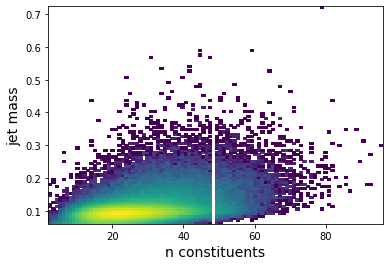

In [12]:
plt.hist2d(nc_sig, sig_jets[:,3], bins=defs.N_CONST, norm=LogNorm());
plt.xlabel("n constituents")
plt.ylabel("jet mass")

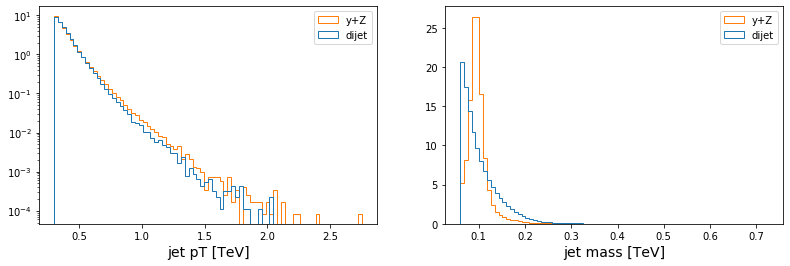

In [13]:
plt.figure(figsize=plt.figaspect(0.3))
plt.subplot(121)
h_sig = plt.hist([bg_jets[:,0], sig_jets[:,0]], histtype='step', bins=80, density=True, label=['dijet','y+Z']);
plt.xlabel("jet pT [TeV]");
plt.yscale('log');
plt.legend()
plt.subplot(122)
plt.hist([bg_jets[:,3], sig_jets[:,3]], histtype='step', bins=80, density=True, label=['dijet', 'y+Z']);
plt.xlabel("jet mass [TeV]");
plt.legend();

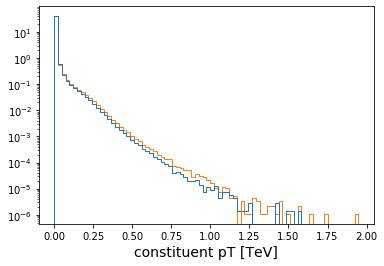

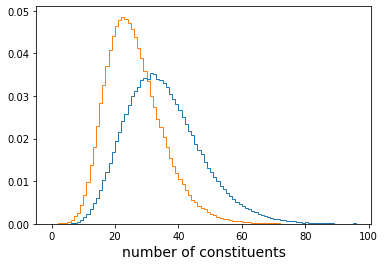

In [16]:
plt.hist([bg_consts[:,:,0].flatten(), sig_consts[:,:,0].flatten()], histtype='step', bins=80, density=True);
plt.yscale('log')
plt.xlabel('constituent pT [TeV]');
plt.figure()
plt.hist([nc_bg, nc_sig], histtype='step', bins=defs.N_CONST, range=(0,defs.N_CONST), density=True);
plt.xlabel("number of constituents");

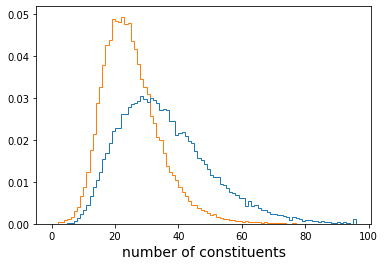

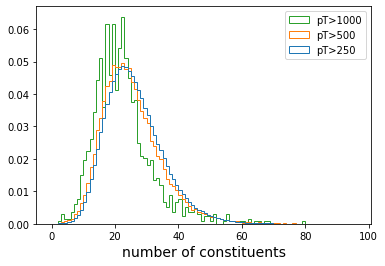

In [17]:
nc_bg500 = np.sum(bg_consts[:,:,0][bg_jets[:,0]>0.5]>0, axis=-1)
nc_sig500 = np.sum(sig_consts[:,:,0][sig_jets[:,0]>0.5]>0, axis=-1)
plt.hist([nc_bg500, nc_sig500], histtype='step', bins=defs.N_CONST, range=(0,defs.N_CONST), density=True);
plt.xlabel("number of constituents");
plt.figure()
nc_bg1000 = np.sum(bg_consts[:,:,0][bg_jets[:,0]>1]>0, axis=-1)
nc_sig1000 = np.sum(sig_consts[:,:,0][sig_jets[:,0]>1]>0, axis=-1)
plt.hist([nc_sig, nc_sig500, nc_sig1000], histtype='step', bins=defs.N_CONST, range=(0,defs.N_CONST), density=True, label=['pT>250','pT>500','pT>1000']);
plt.xlabel("number of constituents");
plt.legend();

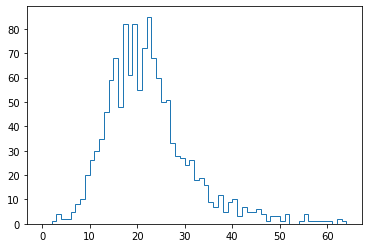

In [18]:
plt.hist(nc_sig1000, histtype='step', bins=64, range=(0,64));

In [19]:
(X_train, y_train), (X_val, y_val) = util.format_dataset(bg_consts, sig_consts,
                                                         validation_fraction=defs.VALIDATION_FRACTION)

#X_train, y_train = X_train[::3], y_train[::3]
#X_val, y_val = X_val[::3], y_val[::3]

X_train.shape

(505298, 96, 3)

In [20]:
X_val.shape

(89168, 96, 3)

In [21]:
def gen_data(X, y, batch_size=32, shuffle_particles=True):
    idxs = np.arange(X.shape[0])
    nbatch = int(X.shape[0]//batch_size)
    
    #pidxs = np.arange(X.shape[1])
    pidxs = np.arange(X.shape[1]).reshape((1,-1)).repeat(batch_size,axis=0)
    
    while True:
        # shuffle event indices
        np.random.shuffle(idxs)
        
        for ibatch in range(nbatch):
            bidxs = idxs[ibatch*batch_size:(ibatch+1)*batch_size]
            
            Xb = X[bidxs]
            yb = y[bidxs]
            
            # shuffle particle indices
            if shuffle_particles:
                #np.random.shuffle(pidxs)
                #Xb = Xb[:,pidxs]
                
                for i in range(batch_size):
                    np.random.shuffle(pidxs[i])
                pt = np.take_along_axis(Xb[:,:,0], pidxs, axis=1)
                eta = np.take_along_axis(Xb[:,:,1], pidxs, axis=1)
                phi = np.take_along_axis(Xb[:,:,2], pidxs, axis=1)
                Xb = np.stack([pt,eta,phi], axis=-1)
                
            yield (Xb, yb)

In [22]:
def mk_HL_calc(n_const):
    model_input = layers.Input((n_const, 3))
    x1 = util.JetVector()(model_input)
    x2 = util.JetECF()(model_input)
    d2 = layers.Lambda(lambda x: x[:,3:4]/100.)(x2) # NB: scaling D2 by 1/100
    model_output = layers.Concatenate(axis=-1)([x1,d2])
    model = Model(model_input, model_output)
    return model
hl_calc = mk_HL_calc(X_train.shape[1])
XH_train = hl_calc.predict(X_train, batch_size=256)
XH_val = hl_calc.predict(X_val, batch_size=256)

W0913 18:09:14.912161 140634271455040 deprecation_wrapper.py:119] From /ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 18:09:14.914625 140634271455040 deprecation_wrapper.py:119] From /ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 18:09:14.957595 140634271455040 deprecation.py:323] From /home/cshimmin/jupyter/adv-attack/util.py:247: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0913 18:09:16.247794 140634271455040 special_math_ops.py:275] Falling back to exponential-space implementation of ei

In [23]:
preds_shuff = next(gen_data(X_train[:4096], y_train[:4096], batch_size=4096))[0]
XH_train_shuff = hl_calc.predict(preds_shuff)

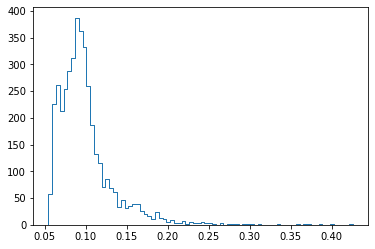

In [24]:
plt.hist([XH_train[:4096,3], XH_train_shuff[:4096,3]], histtype='step', bins=80);

In [25]:
hl_calc_trunc = mk_HL_calc(32)
XH_train_trunc = hl_calc_trunc.predict(X_train[:,:32], batch_size=256)

W0913 18:10:52.133515 140634271455040 special_math_ops.py:275] Falling back to exponential-space implementation of einsum() because index "j" is summed over more than two inputs.
W0913 18:10:52.739067 140634271455040 special_math_ops.py:275] Falling back to exponential-space implementation of einsum() because index "k" is summed over more than two inputs.


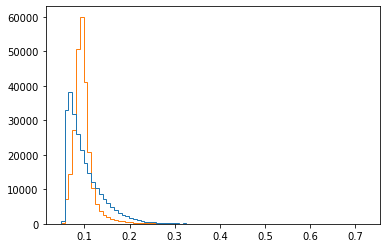

In [26]:
plt.hist([XH_train[:,3][y_train==0],XH_train[:,3][y_train==1]], histtype='step', bins=80);

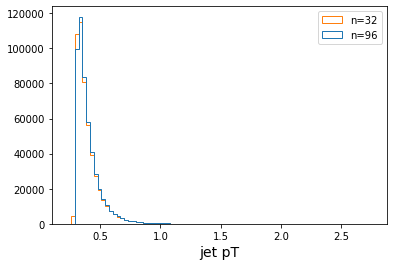

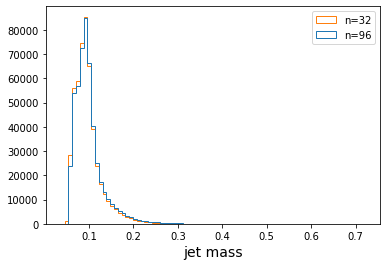

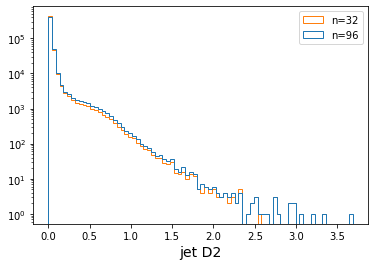

In [27]:
plt.hist([XH_train[:,0], XH_train_trunc[:,0]], histtype='step', bins=80, label=['n=%d'%defs.N_CONST,'n=32']);
plt.xlabel("jet pT")
plt.legend();
plt.figure()
plt.hist([XH_train[:,3], XH_train_trunc[:,3]], histtype='step', bins=80, label=['n=%d'%defs.N_CONST,'n=32']);
plt.xlabel("jet mass")
plt.legend();
plt.figure()
plt.hist([XH_train[:,4], XH_train_trunc[:,4]], histtype='step', bins=80, label=['n=%d'%defs.N_CONST,'n=32']);
plt.xlabel("jet D2")
plt.legend();
plt.yscale('log')

In [28]:
def mk_benchmark_LL(n_const, n_layers=3, n_units=256, dropout=None,
                    res=False, n_res_units=256, batch_norm=False,
                    shuffle_particles=False, randomize_phi=False, optimizer='adam'):
    classifier_input = layers.Input((n_const, 3))
    
    def format_constituents(x):
        pt,eta,phi = tf.split(x, 3, axis=-1)
        phi_sin = tf.sin(phi)
        phi_cos = tf.cos(phi)
        return tf.concat([pt,eta,phi_sin,phi_cos], axis=-1)
    
    x = layers.Lambda(format_constituents)(classifier_input)
    x = layers.Flatten()(x)
    
    if res:
        x = layers.Dense(n_units, activation='relu')(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        if dropout:
            x = layers.Dropout(dropout)(x)
        
        for _ in range(n_layers-1):
            y = layers.Dense(n_res_units, activation='relu')(x)
            if batch_norm:
                y = layers.BatchNormalization()(y)
            if dropout:
                y = layers.Dropout(dropout)(y)
            y = layers.Dense(n_units)(y)
            x = layers.add([x,y])
            x = layers.Activation('relu')(x)
            if batch_norm:
                x = layers.BatchNormalization()(x)
            if dropout:
                x = layers.Dropout(dropout)(x)
            
    else:
        for _ in range(n_layers):
            x = layers.Dense(n_units, activation='relu')(x)
            if dropout:
                x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    
    classifier_output = x
    
    classifier = Model(classifier_input, classifier_output)
    
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    def shuffle(x):
        xsplit = tf.split(x, 2, axis=0)
        xsplit2 = []
        for xs in xsplit:
            xs = tf.transpose(xs, (1,0,2))
            xs = tf.random_shuffle(xs)
            xs = tf.transpose(xs, (1,0,2))
            xsplit2.append(xs)
        return tf.concat(xsplit2, axis=0)
    
    shuf_in = layers.Input((n_const,3))
    shuf_out = layers.Lambda(shuffle)(shuf_in)
    shuffler = Model(shuf_in, shuf_out)
    
    classifier_aug_input = layers.Input((n_const, 3))
    x_aug = classifier_aug_input
    if randomize_phi:
        x_aug = util.RandomizePhi()(x_aug)
    if shuffle_particles:
        x_aug = shuffler(x_aug)
    classifier_aug_output = classifier(x_aug)
    classifier_augmented = Model(classifier_aug_input, classifier_aug_output)
    classifier_augmented.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    
    calc_in = layers.Input((n_const,3))
    calc_out = util.JetVector()(calc_in)
    calc = Model(calc_in, calc_out)
    
    return classifier, classifier_augmented, shuffler, calc

In [29]:
K.clear_session()

shuffle_particles = True
randomize_phi = False

#with tf.device('/cpu:0'):
benchmark_LL_nonaug, benchmark_LL_aug, shuffler, calc = mk_benchmark_LL(defs.N_CONST,
                                                        shuffle_particles=shuffle_particles,
                                                        randomize_phi=randomize_phi,
                                                        **defs.BENCHMARK_LL_ARGS)


benchmark_LL = benchmark_LL_aug

#benchmark_LL = keras.utils.multi_gpu_model(benchmark_LL, gpus=2)
#benchmark_LL.compile(optimizer='adam', loss='binary_crossentropy')

benchmark_LL.h = util.HistoryCB(val_data=(X_val, y_val))

W0913 18:11:04.419105 140634271455040 deprecation_wrapper.py:119] From /ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [30]:
benchmark_LL_nonaug.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 3)             0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 96, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049

In [ ]:
epochs = 128

batch_size = 512 #128


learning_rate = 3e-4

K.set_value(benchmark_LL.optimizer.lr, learning_rate)

stopping = callbacks.EarlyStopping(monitor='val_loss', patience=32, verbose=2,
                                   mode='min', restore_best_weights=True)

use_gen = False
try:
    if not use_gen:
        benchmark_LL.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         callbacks=[benchmark_LL.h],
                         batch_size=batch_size,
                         epochs=epochs
                        )
    else:
        benchmark_LL.fit_generator(gen_data(X_train, y_train,
                                        batch_size=batch_size,
                                        shuffle_particles=shuffle_particles),
                               validation_data=gen_data(X_val, y_val,
                                                         batch_size=batch_size,
                                                        shuffle_particles=shuffle_particles),
                               #callbacks=[benchmark_LL.h, stopping],
                               callbacks=[benchmark_LL.h],
                               steps_per_epoch=X_train.shape[0]//batch_size,
                               validation_steps=X_val.shape[0]//batch_size,
                               epochs=epochs
                              )
except KeyboardInterrupt:
    pass

Train on 505298 samples, validate on 89168 samples
Epoch 1/128
505298/505298 [==============================] - 8s 16us/step - loss: 0.5979 - val_loss: 0.6003
Epoch 2/128
505298/505298 [==============================] - 8s 16us/step - loss: 0.5979 - val_loss: 0.5997
Epoch 3/128
505298/505298 [==============================] - 8s 16us/step - loss: 0.5978 - val_loss: 0.5994
Epoch 4/128
505298/505298 [==============================] - 8s 16us/step - loss: 0.5979 - val_loss: 0.6005
Epoch 5/128
505298/505298 [==============================] - 9s 17us/step - loss: 0.5977 - val_loss: 0.6001
Epoch 6/128
505298/505298 [==============================] - 8s 16us/step - loss: 0.5979 - val_loss: 0.6001
Epoch 7/128
505298/505298 [==============================] - 8s 17us/step - loss: 0.5979 - val_loss: 0.6014
Epoch 8/128
505298/505298 [==============================] - 9s 17us/step - loss: 0.5977 - val_loss: 0.5996
Epoch 9/128
505298/505298 [==============================] - 8s 17us/step - loss: 0.5

Validation AUC: 0.7410372892143522
          best: 0.7416036587762014
         ibest: 271/320


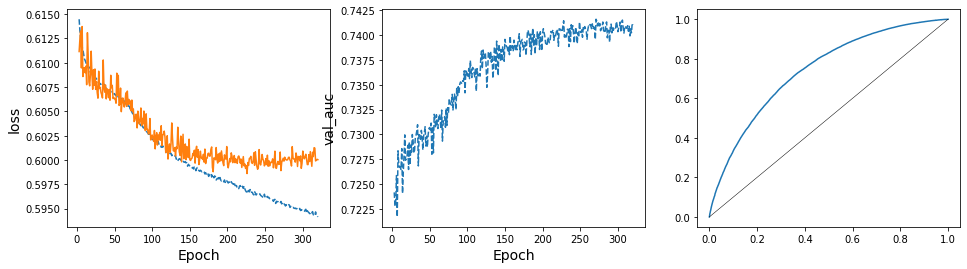

In [107]:
benchmark_LL.h.plot(['loss', 'val_auc', 'roc'], nskip=2,
                    figsize=plt.figaspect(0.25))
print("Validation AUC:", benchmark_LL.h.history['val_auc'][-1])
print("          best:", np.max(benchmark_LL.h.history['val_auc']))
print("         ibest: %d/%d"%(np.argmax(benchmark_LL.h.history['val_auc'])+1, benchmark_LL.h.epoch_total))

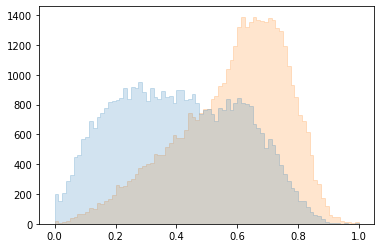

In [108]:
preds_val = benchmark_LL.predict(X_val, batch_size=512).squeeze()
plt.hist([preds_val[y_val==0], preds_val[y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2);

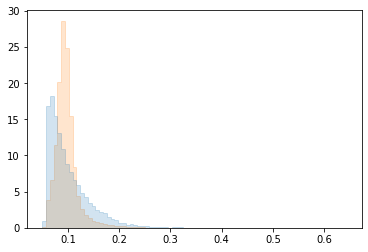

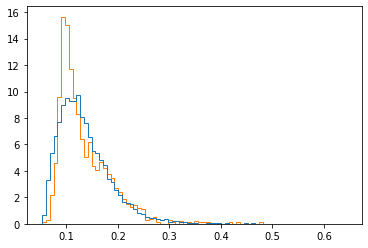

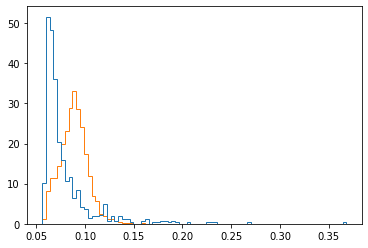

In [109]:
plt.hist([XH_val[:,3][y_val==0], XH_val[:,3][y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2, density=True);
plt.figure()
plt.hist([XH_val[:,3][(y_val==0)*(preds_val<0.2)], XH_val[:,3][(y_val==1)*(preds_val<0.2)]], histtype='step', bins=80, density=True);
plt.figure()
plt.hist([XH_val[:,3][(y_val==0)*(preds_val>0.8)], XH_val[:,3][(y_val==1)*(preds_val>0.8)]], histtype='step', bins=80, density=True);

0.0
0.39875249564647675
0.5373066782951355
0.6831179201602938
0.7352621287107468
0.8179980200529098


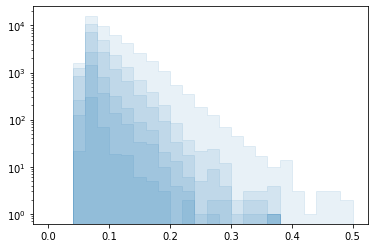

In [110]:
for q in np.quantile(preds_val[y_val==0], (0,0.5,0.7,0.9,0.95,0.99)):
    print(q)
    plt.hist(XH_val[:,3][(y_val==0)*(preds_val>q)], histtype='step', bins=25, range=(0,0.5), color='C0', alpha=0.1, fill=True)
plt.yscale('log');

1.0
0.6144413948059082
0.5042118191719055
0.3202010333538055
0.24260077625513088
0.1223891177773477


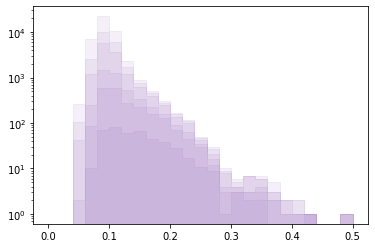

In [111]:
for q in np.quantile(preds_val[y_val==1], (1-0.0,1-0.5,1-0.7,1-0.9,1-0.95,1-0.99)):
    print(q)
    plt.hist(XH_val[:,3][(y_val==1)*(preds_val<q)], histtype='step', bins=25, range=(0,0.5), color='C4', alpha=0.1, fill=True)
plt.yscale('log');

In [112]:
save_model = False

if save_model:
    if shuffle_particles:
        file_name = 'model_benchmark_LL_shuff.h5'
    else:
        file_name = 'model_benchmark_LL.h5'
    
    benchmark_LL_nonaug.save(file_name)
    print("Saved to", file_name)

In [33]:
def mk_benchmark_HL(n_feature=5, n_layers=3, n_units=256, dropout=None):
    classifier_input = layers.Input((n_feature,))
    
    x = classifier_input
    
    def format_jets(x):
        features = tf.split(x, n_feature, axis=-1)
        phi = features[2]
        phi_sin = tf.sin(phi)
        phi_cos = tf.cos(phi)
        return tf.concat(features[:2]+features[3:] + [phi_sin,phi_cos], axis=-1)
    
    x = layers.Lambda(format_jets)(x)
    
    for _ in range(n_layers):
        x = layers.Dense(n_units, activation='relu')(x)
        if dropout:
            x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    
    classifier_output = x
    
    classifier = Model(classifier_input, classifier_output)
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy')
    
    
    
    classifier_aug_input = layers.Input((n_feature,))
    x = util.RandomizeJetPhi()(classifier_aug_input)
    classifier_aug_output = classifier(x)
    classifier_aug = Model(classifier_aug_input, classifier_aug_output)
    classifier_aug.compile(optimizer='adam', loss='binary_crossentropy')
    
    
    return classifier, classifier_aug

In [52]:
K.clear_session()
benchmark_HL_nonaug, benchmark_HL_aug = mk_benchmark_HL(**defs.BENCHMARK_HL_ARGS)

benchmark_HL = benchmark_HL_nonaug

benchmark_HL.h = util.HistoryCB(val_data=(XH_val, y_val))

In [53]:
benchmark_HL_nonaug.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 384)               2688      
_________________________________________________________________
dropout_1 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 384)               147840    
_________________________________________________________________
dropout_2 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 384)               1478

In [66]:
epochs = 16

batch_size = 128

learning_rate = 3e-4

K.set_value(benchmark_HL.optimizer.lr, learning_rate)

stopping = callbacks.EarlyStopping(monitor='val_loss', patience=32, verbose=1,
                                   mode='min', restore_best_weights=True)

try:
    benchmark_HL.fit(XH_train, y_train,
                     validation_data=(XH_val, y_val),
                     callbacks=[benchmark_HL.h, stopping],
                     batch_size=batch_size,
                     epochs=epochs
                    )
except KeyboardInterrupt:
    pass

Train on 505298 samples, validate on 89168 samples
Epoch 1/16
505298/505298 [==============================] - 25s 50us/step - loss: 0.5416 - val_loss: 0.5381
Epoch 2/16
505298/505298 [==============================] - 25s 49us/step - loss: 0.5419 - val_loss: 0.5361
Epoch 3/16
505298/505298 [==============================] - 25s 49us/step - loss: 0.5415 - val_loss: 0.5378
Epoch 4/16
505298/505298 [==============================] - 25s 49us/step - loss: 0.5415 - val_loss: 0.5374
Epoch 5/16
505298/505298 [==============================] - 25s 49us/step - loss: 0.5417 - val_loss: 0.5369
Epoch 6/16
505298/505298 [==============================] - 25s 49us/step - loss: 0.5414 - val_loss: 0.5364
Epoch 7/16
505298/505298 [==============================] - 25s 49us/step - loss: 0.5413 - val_loss: 0.5374
Epoch 8/16
505298/505298 [==============================] - 25s 50us/step - loss: 0.5414 - val_loss: 0.5370
Epoch 9/16
505298/505298 [==============================] - 25s 49us/step - loss: 0.5

Validation AUC: 0.8043999651631291
          best: 0.8055037403875625
         ibest: 43/48


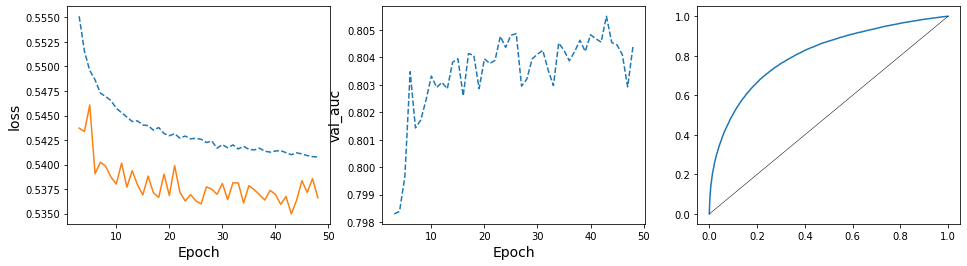

In [67]:
benchmark_HL.h.plot(['loss', 'val_auc', 'roc'], nskip=2, figsize=plt.figaspect(0.25))
print("Validation AUC:", benchmark_HL.h.history['val_auc'][-1])
print("          best:", np.max(benchmark_HL.h.history['val_auc']))
print("         ibest: %d/%d"%(np.argmax(benchmark_HL.h.history['val_auc'])+1,benchmark_HL.h.epoch_total))

In [71]:
save_model = False

if save_model:
    benchmark_LL_nonaug.save('model_benchmark_HL.h5')